# Stratified Inverse Transform Sampling — overview

Stratified inverse transform is a variance-reduction variant of the inverse transform method.

- Inverse transform (baseline): draw i.i.d. uniforms U ~ Uniform(0, 1) and map each to samples via X = F^{-1}(U).
- Stratified inverse transform: partition [0, 1] into n equally sized strata [i/n, (i+1)/n), draw one uniform per stratum, U_i = i/n + V_i/n with V_i ~ Uniform(0, 1), then set X_i = F^{-1}(U_i).

What changes and why it helps
- Coverage of the CDF domain: ensures each region of [0,1] is represented, reducing clustering/gaps you get with purely i.i.d. uniforms.
- Unbiasedness: the estimator of E[g(X)] remains unbiased, while the variance of sample means typically decreases—often substantially for monotone g∘F^{-1}.
- Practical note: for one sample per stratum, use n_strata = n_samples; with unequal n, allocate samples proportionally across strata.

In this notebook we use StratifiedInverseTransformSampler wrapped around a base InverseTransformSampler (analytical inverse for the exponential distribution). This mirrors classical stratification on the uniform driver and then applies the inverse CDF.

References
1. Christian P. Robert and George Casella (2004). Monte Carlo Statistical Methods (2nd ed.). Springer. 
2. Paul Glasserman (2004). Monte Carlo Methods in Financial Engineering. Springer. 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import levene

from mc_lab.inverse_transform import (
    InverseTransformSampler,
    StratifiedInverseTransformSampler,
)

# Set random seed for reproducibility
np.random.seed(42)

In [9]:
# Parameters for exponential distribution
lambda_param = 2.0  # rate parameter


def exponential_inverse_cdf(u, lam):
    """Inverse CDF of exponential distribution: F^(-1)(u) = -ln(1-u)/λ"""
    return -np.log(1 - u) / lam


# Create base sampler using the analytical inverse CDF
base_sampler = InverseTransformSampler(
    inverse_cdf=lambda u: exponential_inverse_cdf(u, lambda_param)
)

# Comparison parameters
n_samples = 100
n_trials = 1000

# Stratified sampler with one sample per stratum (n_strata = n_samples)
stratified_sampler = StratifiedInverseTransformSampler(
    base_sampler=base_sampler, n_strata=n_samples
)

# Storage for results
regular_means = []
stratified_means = []
regular_variances = []
stratified_variances = []

print("Running comparison...")
print(f"True mean of Exp({lambda_param}): {1 / lambda_param:.3f}")
print(f"True variance of Exp({lambda_param}): {1 / lambda_param**2:.3f}")
print()

# Run multiple trials
for trial in range(n_trials):
    # Regular sampling
    regular_samples = base_sampler.sample(n_samples)
    regular_means.append(np.mean(regular_samples))
    regular_variances.append(np.var(regular_samples, ddof=1))

    # Stratified sampling
    stratified_samples = stratified_sampler.sample(n_samples)
    stratified_means.append(np.mean(stratified_samples))
    stratified_variances.append(np.var(stratified_samples, ddof=1))

# Convert to arrays
regular_means = np.array(regular_means)
stratified_means = np.array(stratified_means)
regular_variances = np.array(regular_variances)
stratified_variances = np.array(stratified_variances)

# Calculate variance of the estimators (variance of sample means)
var_regular_estimator = np.var(regular_means)
var_stratified_estimator = np.var(stratified_means)

Running comparison...
True mean of Exp(2.0): 0.500
True variance of Exp(2.0): 0.250



In [10]:
# Results
print("VARIANCE REDUCTION RESULTS:")
print("=" * 50)
print(f"Variance of regular estimator:     {var_regular_estimator:.6f}")
print(f"Variance of stratified estimator:  {var_stratified_estimator:.6f}")
print(
    f"Variance reduction factor:         {var_regular_estimator / var_stratified_estimator:.2f}"
)
print(
    f"Percentage reduction:              {(1 - var_stratified_estimator / var_regular_estimator) * 100:.1f}%"
)
print()

print("SAMPLE STATISTICS:")
print("=" * 50)
print(f"Mean of regular means:     {np.mean(regular_means):.4f}")
print(f"Mean of stratified means:  {np.mean(stratified_means):.4f}")
print(f"Std of regular means:      {np.std(regular_means):.4f}")
print(f"Std of stratified means:   {np.std(stratified_means):.4f}")

VARIANCE REDUCTION RESULTS:
Variance of regular estimator:     0.002423
Variance of stratified estimator:  0.000031
Variance reduction factor:         78.07
Percentage reduction:              98.7%

SAMPLE STATISTICS:
Mean of regular means:     0.4992
Mean of stratified means:  0.5004
Std of regular means:      0.0492
Std of stratified means:   0.0056


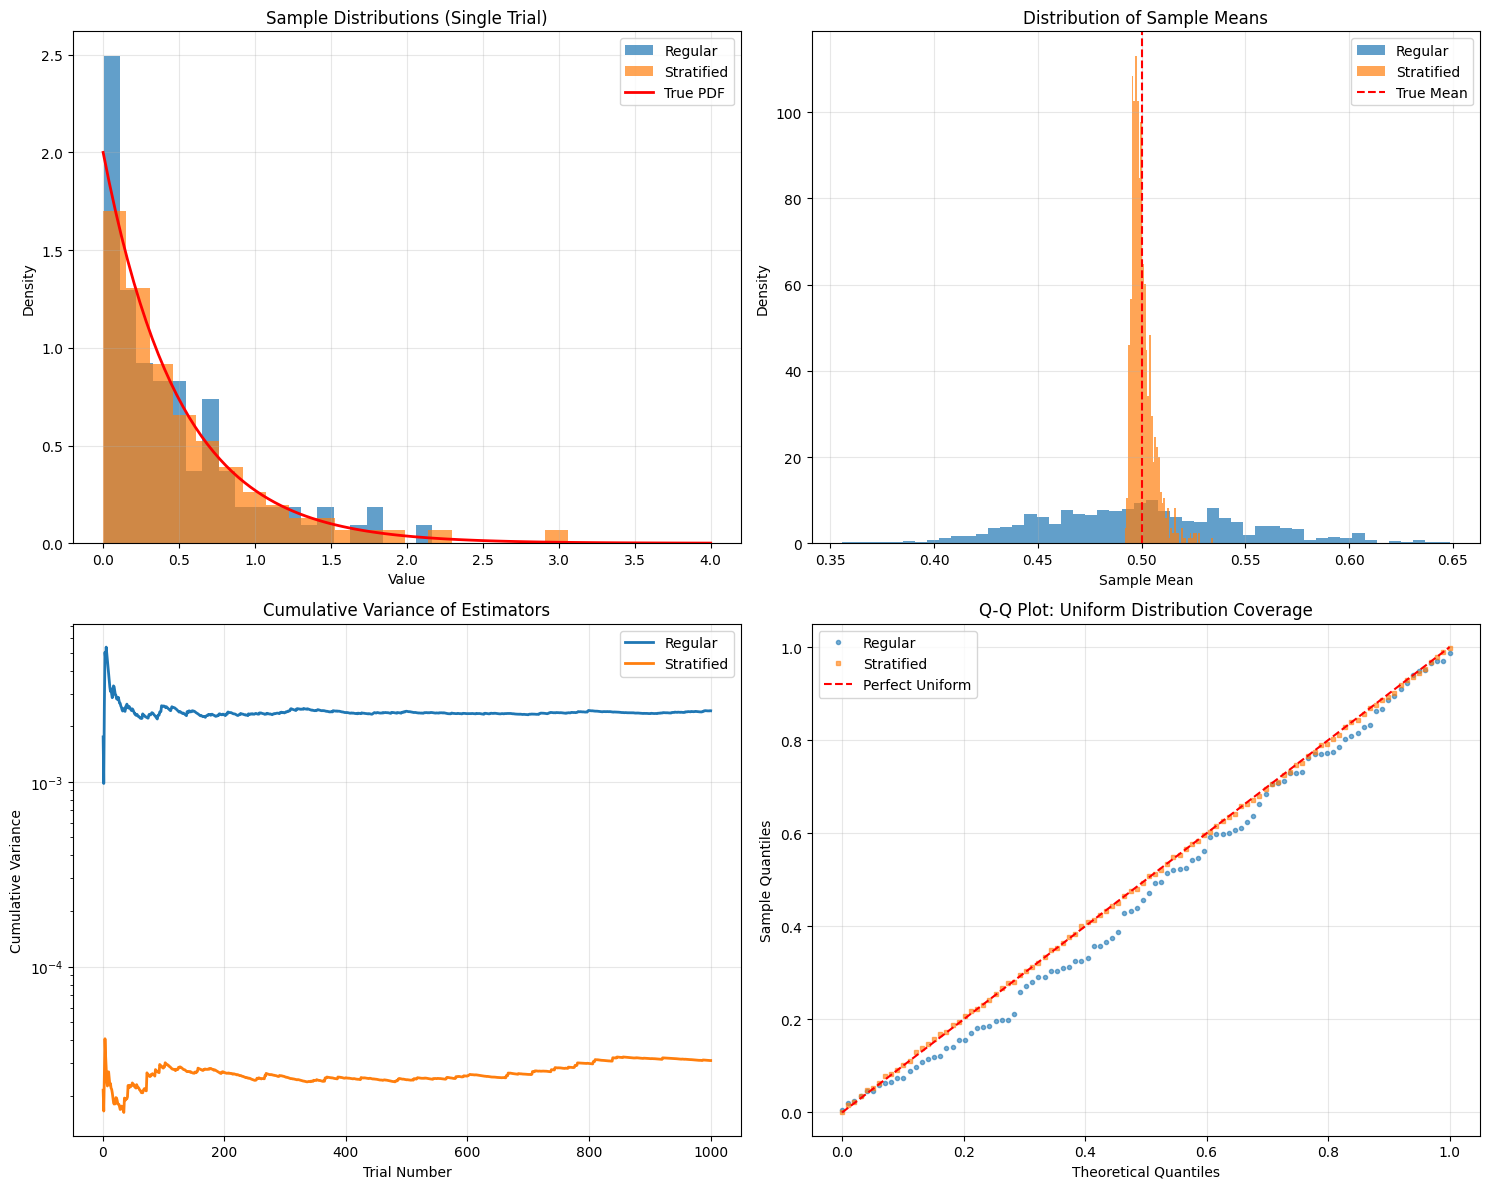

In [11]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sample distributions comparison (single trial)
np.random.seed(42)  # Reset for consistent visualization
regular_sample = base_sampler.sample(n_samples)
stratified_sample = stratified_sampler.sample(n_samples)

axes[0, 0].hist(regular_sample, bins=20, alpha=0.7, label="Regular", density=True)
axes[0, 0].hist(stratified_sample, bins=20, alpha=0.7, label="Stratified", density=True)
x_range = np.linspace(0, 4, 100)
axes[0, 0].plot(
    x_range,
    lambda_param * np.exp(-lambda_param * x_range),
    "r-",
    linewidth=2,
    label="True PDF",
)
axes[0, 0].set_title("Sample Distributions (Single Trial)")
axes[0, 0].set_xlabel("Value")
axes[0, 0].set_ylabel("Density")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of sample means
axes[0, 1].hist(regular_means, bins=50, alpha=0.7, label="Regular", density=True)
axes[0, 1].hist(stratified_means, bins=50, alpha=0.7, label="Stratified", density=True)
axes[0, 1].axvline(1 / lambda_param, color="red", linestyle="--", label="True Mean")
axes[0, 1].set_title("Distribution of Sample Means")
axes[0, 1].set_xlabel("Sample Mean")
axes[0, 1].set_ylabel("Density")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Variance comparison over trials
trial_numbers = np.arange(1, n_trials + 1)
cumulative_var_regular = (
    np.cumsum((regular_means - np.mean(regular_means)) ** 2) / trial_numbers
)
cumulative_var_stratified = (
    np.cumsum((stratified_means - np.mean(stratified_means)) ** 2) / trial_numbers
)

axes[1, 0].plot(trial_numbers, cumulative_var_regular, label="Regular", linewidth=2)
axes[1, 0].plot(
    trial_numbers, cumulative_var_stratified, label="Stratified", linewidth=2
)
axes[1, 0].set_title("Cumulative Variance of Estimators")
axes[1, 0].set_xlabel("Trial Number")
axes[1, 0].set_ylabel("Cumulative Variance")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale("log")

# 4. Q-Q plot showing uniformity of u values
np.random.seed(42)
u_regular = np.random.uniform(0, 1, n_samples)
u_stratified = np.arange(n_samples) / n_samples + np.random.uniform(
    0, 1 / n_samples, n_samples
)

# Sort for Q-Q plot
u_regular_sorted = np.sort(u_regular)
u_stratified_sorted = np.sort(u_stratified)
theoretical_quantiles = np.linspace(0, 1, n_samples)

axes[1, 1].plot(
    theoretical_quantiles,
    u_regular_sorted,
    "o",
    alpha=0.6,
    label="Regular",
    markersize=3,
)
axes[1, 1].plot(
    theoretical_quantiles,
    u_stratified_sorted,
    "s",
    alpha=0.6,
    label="Stratified",
    markersize=3,
)
axes[1, 1].plot([0, 1], [0, 1], "r--", label="Perfect Uniform")
axes[1, 1].set_title("Q-Q Plot: Uniform Distribution Coverage")
axes[1, 1].set_xlabel("Theoretical Quantiles")
axes[1, 1].set_ylabel("Sample Quantiles")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Statistical test for variance reduction
print("\nSTATISTICAL SIGNIFICANCE:")
print("=" * 50)


stat, p_value = levene(regular_means, stratified_means)
print("Levene's test for equal variances:")
print(f"Test statistic: {stat:.4f}")
print(f"P-value: {p_value:.2e}")
if p_value < 0.05:
    print("Variances are significantly different (p < 0.05)")
else:
    print("No significant difference in variances (p ≥ 0.05)")

# Efficiency comparison
efficiency_gain = var_regular_estimator / var_stratified_estimator
print("\nEFFICIENCY GAIN:")
print("=" * 50)
print(f"To achieve the same precision as {n_samples} stratified samples,")
print(
    f"you would need approximately {int(n_samples * efficiency_gain)} regular samples."
)
print(f"This represents a {efficiency_gain:.1f}x efficiency improvement.")


STATISTICAL SIGNIFICANCE:
Levene's test for equal variances:
Test statistic: 1396.8677
P-value: 2.80e-232
Variances are significantly different (p < 0.05)

EFFICIENCY GAIN:
To achieve the same precision as 100 stratified samples,
you would need approximately 7806 regular samples.
This represents a 78.1x efficiency improvement.


In [13]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [14]:
%watermark -a "Carsten Jørgensen" -u -d -v -m  --iversions

Author: Carsten Jørgensen

Last updated: 2025-08-18

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 9.4.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.6.87.2-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 22
Architecture: 64bit

mc_lab    : 0.1.0
scipy     : 1.16.1
sys       : 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
numpy     : 2.2.6
matplotlib: 3.10.5

